In [1]:
import random
import pandas as pd
import numpy as np 
import re 
from llmft.utils import predict
import seaborn as sns  # Assuming seaborn is installed


In [2]:
data_csv = f'./../../../toy-data/exp2/data_1.csv'

In [3]:
n = 1000
prompt = True

In [4]:
conditions_not_covered = [
    "Short-term illnesses",
    "Temporary exhaustion",
    "Behavioral Traits and Conditions",
    "Having a quick temper without any underlying medical condition",
    "Certain Addictions",
    "Substance abuse disorders",
    "good health"
]

conditions_covered = [
    "Mobility impairments",
    "Visual impairments",
    "Hearing impairments",
    "Chronic illnesses",
    "Respiratory disorders",
    "Cardiovascular conditions",
    "Intellectual disabilities",
    "Learning disabilities",
    "Autism spectrum disorders",
    "Psychiatric disorders",
    "Traumatic brain injuries",
    "Alzheimer's disease and other dementias"
]

disabilities = conditions_covered + conditions_not_covered

# Create a list of (0,1)s
severity_indicator = [1 if disability in conditions_covered else 0 for disability in disabilities]

def fstage(var1, var2, var3, var4, var5, var6, var7, var8, var9):
    return 0.35*severity_indicator[var5] + 0.35*var9

In [5]:

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

string_b = 'Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.\n\n Description:'
string1 = "\n\n Note: The tenant has access to a free lawyer."
string0 = "\n\n Note: The tenant does not have access to a free lawyer."
if prompt:
    string1 += " Access to a lawyer does not mean the tenant will be represented in court by a lawyer." \
        " If the tenant is given access to a lawyer, they must apply for representation." \
        " Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications." \
        " Providers can differ over what they consider to be a dissability."\
        " If a tenant's application is selected, they must follow-up with the provider to arange for legal representation." \
        " Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation."
    

df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=n, replace=False)
df = df.loc[indices].reset_index(drop=True)
# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4'], 
                                                 row['Var5'],
                                                 row['Var6'],
                                                 row['Var7'],
                                                 row['Var8'],
                                                 row['Var9']), axis=1)
# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=n)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1,
                             string_b + df['Description'] + string1,
                             string_b + df['Description'] + string0)

df['label'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=n)

df.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Description,FStage_Value,Instrument,FullDescription,label
0,6,1,3,1202,0,50,0,0,0,The tenant is a mid-40s individual with mobili...,0.35,1,"Based on the following information, predict (Y...",1
1,0,1,2,925,0,27,0,0,1,The tenant is a 26-year-old individual with mo...,0.70,1,"Based on the following information, predict (Y...",1
2,7,1,0,1340,0,42,1,0,1,The tenant is a late-40s individual with mobil...,0.70,1,"Based on the following information, predict (Y...",1
3,7,3,1,1450,0,28,0,0,0,The tenant is a middle-aged individual in thei...,0.35,1,"Based on the following information, predict (Y...",0
4,4,2,2,704,0,47,0,1,0,The tenant is a 37-year-old individual with mo...,0.35,1,"Based on the following information, predict (Y...",0


In [6]:
df[['Description', 'label']]

,Description,label
0,The tenant is a mid-40s individual with mobili...,1
1,The tenant is a 26-year-old individual with mo...,1
2,The tenant is a late-40s individual with mobil...,1
3,The tenant is a middle-aged individual in thei...,0
4,The tenant is a 37-year-old individual with mo...,0
...,...,...
995,The tenant is a young adult in their mid-20s w...,1
996,The tenant is a 37-year-old individual who is ...,0
997,The tenant is a mid-50s individual with mobili...,0
998,The tenant is a 57-year-old individual with in...,0


In [7]:
var = "Description"
data = df

In [8]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader


model_id = "microsoft/phi-3-mini-4k-instruct" #"microsoft/phi-3-mini-4k-instruct" # "meta-llama/Meta-Llama-3-8B-Instruct" #"meta-llama/Meta-Llama-3-8B" # #
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

def tokenizer_function(example):
  return tokenizer(example[var], truncation=True, max_length=512)

dataset = Dataset.from_dict(data[[var,'label']])
tokenized_dataset = dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns([var])

data_loader = DataLoader(tokenized_dataset, batch_size=8, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
import torch
from transformers import Phi3ForSequenceClassification, AdamW
model_id = "microsoft/phi-3-mini-4k-instruct"

# Load the model
model = Phi3ForSequenceClassification.from_pretrained(model_id,
                                                           device_map='auto',
                                                           num_labels=2, 
                                                           torch_dtype=torch.bfloat16,
                                                           attn_implementation="flash_attention_2")

model.gradient_checkpointing_enable()
model.config.use_cache = False # Doesn't work with gradient checkpointing.

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Phi3ForSequenceClassification were not initialized from the model checkpoint at microsoft/phi-3-mini-4k-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [11]:
losses = []

model.train()
for epoch in range(20):  # Training for 3 epochs
    for batch in data_loader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Calculate the loss
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        losses.append(loss.detach().item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.373046875
Epoch 2, Loss: 0.369140625
Epoch 3, Loss: 0.345703125
Epoch 4, Loss: 0.37109375
Epoch 5, Loss: 0.34375
Epoch 6, Loss: 0.291015625
Epoch 7, Loss: 0.453125
Epoch 8, Loss: 0.09423828125
Epoch 9, Loss: 0.06787109375
Epoch 10, Loss: 0.051513671875
Epoch 11, Loss: 0.004547119140625
Epoch 12, Loss: 0.0034637451171875
Epoch 13, Loss: 0.0029449462890625


KeyboardInterrupt: 

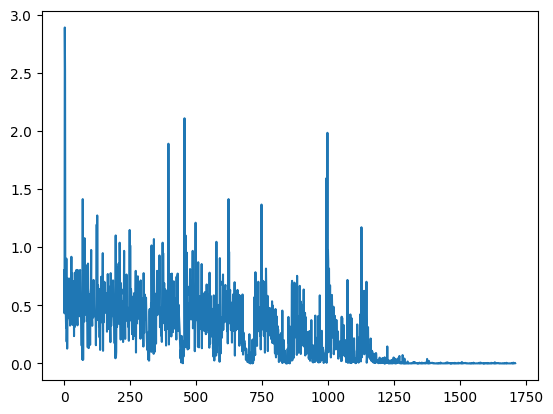

In [12]:
import matplotlib.pyplot as plt 
plt.plot(losses)

In [13]:
Dhat, _ = predict(model, data_loader, device)
Dhat = Dhat.reshape(-1,1)

In [14]:
print(np.min(Dhat), np.max(Dhat))

9.837095e-09 1.0


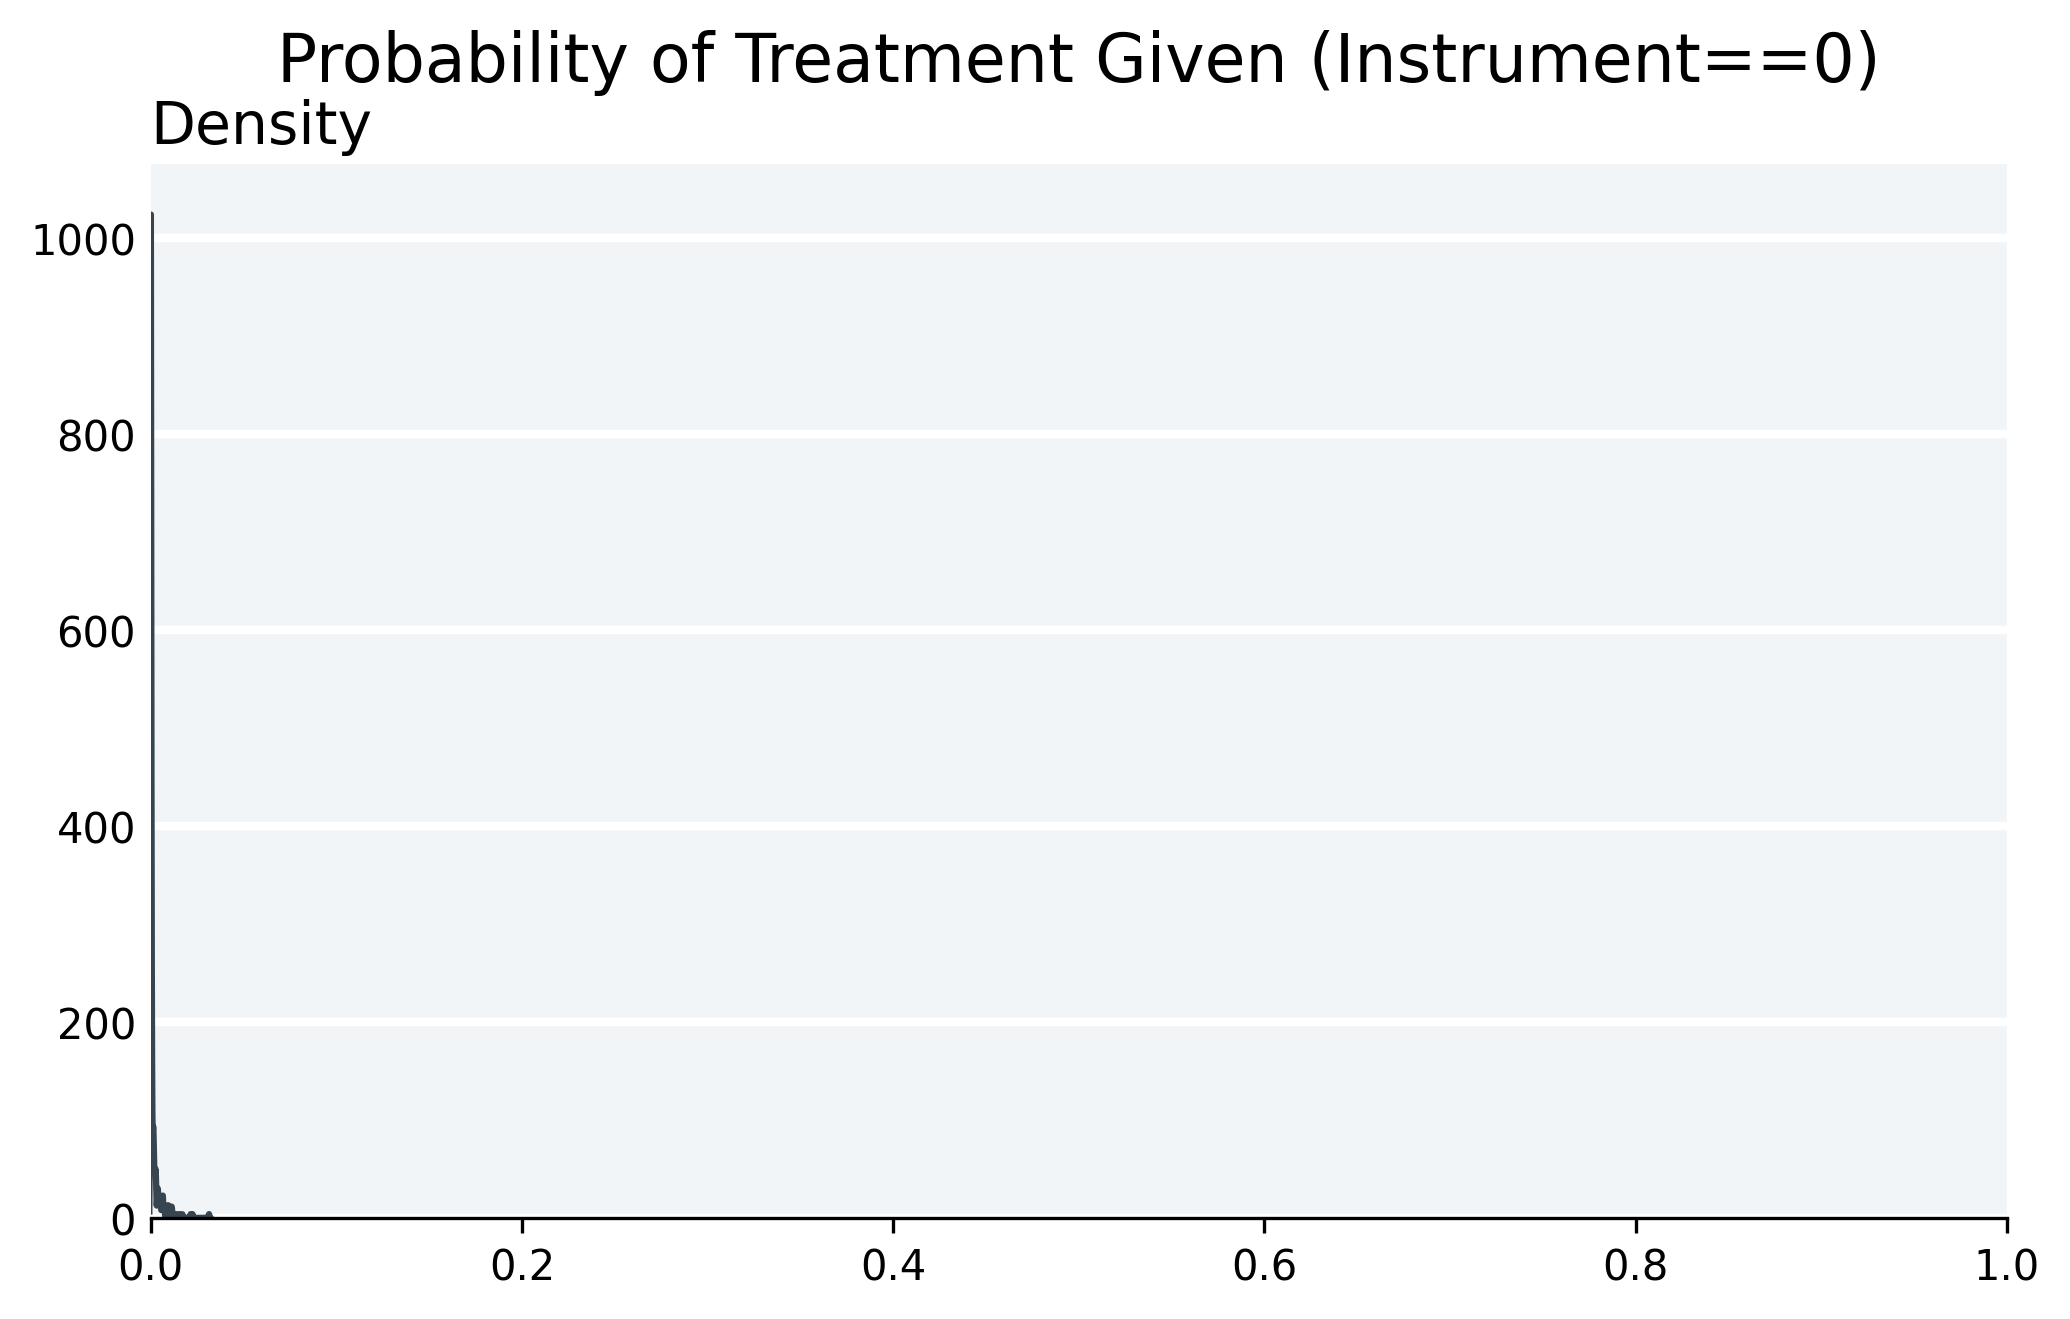

In [15]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.set_title('Probability of Treatment Given (Instrument==0)', size=16, pad=20)

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

# Plot the KDE plot
sns.kdeplot(Dhat[df['Instrument'].values==0].reshape(-1,), color='#36454F', fill=False, bw_adjust=0.25)
plt.xlim(0, 1)
plt.ylabel('')
plt.show()